In [112]:
from keras.models import load_model
import pandas as pd
import numpy as np
import keras
from keras import backend as K
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
import seaborn as sns

## Stacking of ResNet and U-Net

As shown, ResNet has a high false negative rate on classification prediction while U-Net has a high positive rate. Overall, the diagnosis accuracy of ResNet is higher, but the high false negative rate of ResNet may lead to ignorance of lesions. We hope stacking of the models can enhance diagnosis accuracy while bringing down false negative rate.

In [16]:
# load training data

file_path_train = pd.read_csv('mass_training_path.csv')

X_train = []
y_train = []
LEN = 0

for index, row in file_path_train.iterrows():
    try:
        arr = np.load(row['train_X'])
        X_train.append(arr)
        y_train.append(row['label'])
        LEN += 1
    except ValueError:
        print('Skip {} row...'.format(index))
    
#     arr_y = np.load(row['train_y'])
#     y.append(int(np.max(arr_y)))

SIZE = 256
DIM = 1
    
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = X_train.reshape(LEN, SIZE, SIZE, DIM)

#normalize
X_train = X_train / 65535

#to categorical
y_train = keras.utils.to_categorical(y_train, None)

In [ ]:
# load testing data

file_path_test = pd.read_csv('mass_testing_path.csv')

# read in X_test, y_test, and also y_test_pixel
# We need pixel-by-pixel information from y_test for later metrics calculation
X_test = []
y_test = []
y_test_pixel = []
LEN = 0

for index, row in file_path_test.iterrows():
    try:
        arr = np.load(row['test_X'])
        X_test.append(arr)
        y_test.append(row['label'])
        y_test_pixel.append(np.load(row['test_y']))
        LEN += 1
    except ValueError:
        print('Skip {} row...'.format(index))

SIZE = 256
DIM = 1
    
X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.reshape(LEN, SIZE, SIZE, DIM)

#normalize
X_test = X_test / 65535
y_test_pixel = np.array(y_test_pixel) / 255


#to categorical
y_test = keras.utils.to_categorical(y_test, None)

print(X_test.shape)
print(y_test.shape)

In [26]:
# load models

num_one = np.sum(y_train)
num_zero = np.product(y_train.shape)
one_weight = (num_one + num_zero)/num_one
zero_weight = (num_one + num_zero)/num_zero

def adjweighted_crossentropy(y_true, y_pred):
    entropy = K.binary_crossentropy(y_true, y_pred)
    weight_map = y_true * one_weight/2 + (1. - y_true) * zero_weight    
    weighted_entropy = weight_map * entropy
    return K.mean(weighted_entropy)

def diagnosis_acc(y_true, y_pred):
    true = K.squeeze(y_true,axis=-1)
    pred = K.squeeze(y_pred,axis=-1)
    true = K.max(true,axis=[1,2])
    pred = K.max(pred,axis=[1,2])
    return keras.metrics.binary_accuracy(true, pred)

def IoU(y_true, y_pred): # Region Intersection over Union
    y_pred = K.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection/union

u_net = load_model('unet_50weight.h5', custom_objects={'adjweighted_crossentropy': adjweighted_crossentropy,
                                          'diagnosis_acc': diagnosis_acc,
                                          'IoU': IoU})
res_net = load_model("model_0.h5")
res_u_net = load_model('resunet.h5', custom_objects={'adjweighted_crossentropy': adjweighted_crossentropy,
                                          'diagnosis_acc': diagnosis_acc,
                                          'IoU': IoU})

As we have discussed, the false negative rate of ResNet is rather high, which may affect patients in a really bad way as some tumors will be unalarmed. As shown below, the AUC of ResNet is low even though it has a high accuracy. And we also notice that it may not be a good idea to use U-Net for diagnosis classification because the diagnosis accuracy of this classifier is low and its false positive rate is too high, which may lead to manifested waste on medical resrouces.

We stack the 3 models (ResNet, U-Net, U-Net with shortcut connections) by retrieving prediction probabilities from the models and feed them into an SVM model. We give more weight to observations whose class is 'abnormal' to control false negative rate.

AUC of the classifier is 0.6770367728033658


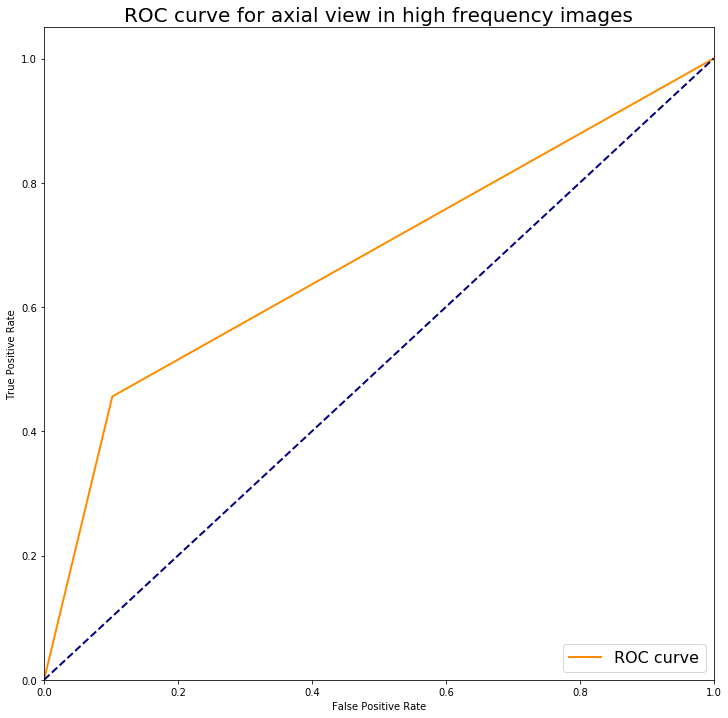

<Figure size 432x288 with 0 Axes>

In [125]:
prediction = res_net.predict(X_test)
prediction_y = [round(p[1]) for p in prediction]
fpr, tpr, thresholds = roc_curve(test_y, prediction_y)
print("AUC of the classifier is {}".format(auc(fpr, tpr)))
plt.figure(figsize=(12,12))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for axial view in high frequency images', fontsize = 20)
plt.legend(loc = 'lower right', fontsize = 16)
plt.show()
plt.savefig("ROC_low_frequency.png")
plt.show()

In [73]:
prediction = res_net.predict(X_train)
res_net_probability = [p[1] for p in prediction]
prediction = u_net.predict(X_train)
u_net_probability = [max(p.flatten()) for p in prediction]
prediction = res_u_net.predict(X_train)
res_u_net_probability = [max(p.flatten()) for p in prediction]
train_X = pd.DataFrame()
train_X['res_net_probability'] = res_net_probability
train_X['u_net_probability'] = u_net_probability
train_X['res_u_net_probability'] = res_u_net_probability
train_y = file_path_train['label']
prediction = res_net.predict(X_test)
res_net_probability = [p[1] for p in prediction]
prediction = u_net.predict(X_test)
u_net_probability = [max(p.flatten()) for p in prediction]
prediction = res_u_net.predict(X_test)
res_u_net_probability = [max(p.flatten()) for p in prediction]
test_y = file_path_test['label']
test_X = pd.DataFrame()
test_X['res_net_probability'] = res_net_probability
test_X['u_net_probability'] = u_net_probability
test_X['res_u_net_probability'] = res_u_net_probability

Accuracy of the model on the training data set is 0.7903766115115217


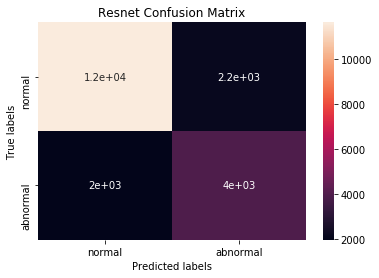

In [119]:
clf = SVC(gamma='auto', class_weight={0:2,1:3}, probability=True)
clf.fit(train_X, train_y)
print("Accuracy of the model on the training data set is {}".format(clf.score(train_X, train_y)))
matrix = confusion_matrix(train_y, clf.predict(train_X))
ax = plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Resnet Confusion Matrix'); 
ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal']);

Accuracy of the model on the testing data set is 0.7748071979434448


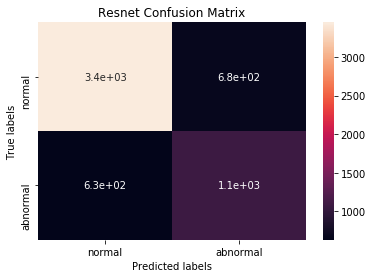

In [110]:
print("Accuracy of the model on the testing data set is {}".format(clf.score(test_X, test_y)))
matrix = confusion_matrix(test_y, clf.predict(test_X))
ax = plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Resnet Confusion Matrix'); 
ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal']);

AUC of the classifier is 0.8006534527101282


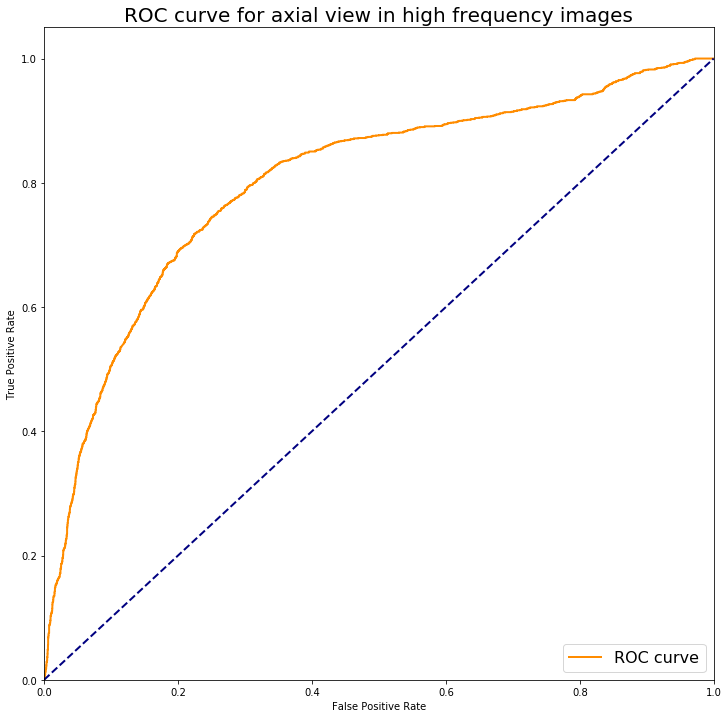

<Figure size 432x288 with 0 Axes>

In [121]:
prediction = clf.predict_proba(test_X)
fpr, tpr, thresholds = roc_curve(test_y, [p[1] for p in prediction])
print("AUC of the classifier is {}".format(auc(fpr, tpr)))
plt.figure(figsize=(12,12))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for axial view in high frequency images', fontsize = 20)
plt.legend(loc = 'lower right', fontsize = 16)
plt.show()
plt.savefig("ROC_low_frequency.png")
plt.show()

The stacking model achieves a diagnosis accuracy of 0.77 (highest among all the models) while keeping false negative rate low. And AUC of the model is 0.8, which means it can be considered into realistic medical application.